In [73]:
import os
import tarfile
import urllib
import numpy as np
import pandas as pd
import joblib
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit as SSS
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from scipy import stats

In [57]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok = True) # Create directory if not already there
    tgz_path = os.path.join(housing_path, 'housing.tgz') # Make path for our tgz file
    urllib.request.urlretrieve(housing_url, tgz_path) # Download the file
    housing_tgz = tarfile.open(tgz_path) # Open the file
    housing_tgz.extractall(path=housing_path) # Extract from tarfile
    housing_tgz.close()

In [4]:
fetch_housing_data()

In [5]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [6]:
housing = load_housing_data()
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
# We can see that ocean_proximity is the only non numerical feature
# We use value_counts to look at what the categories consist of

housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

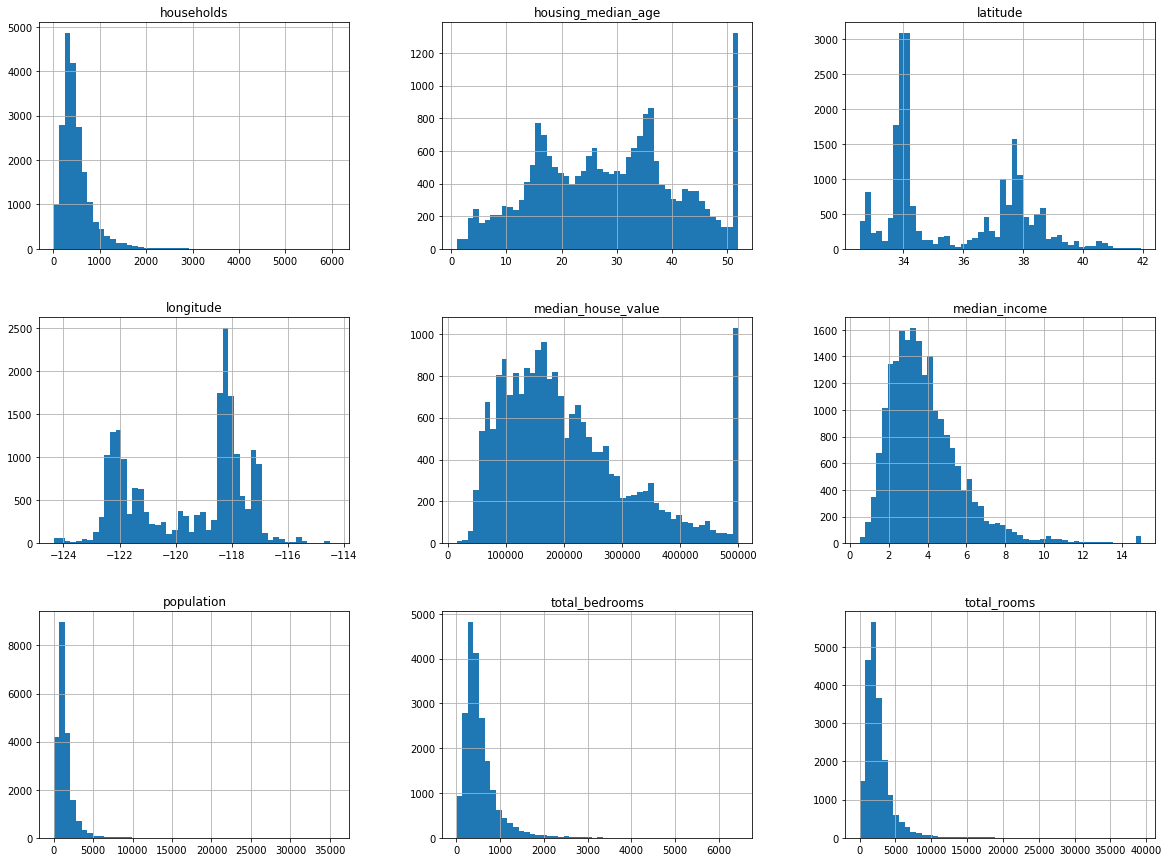

In [10]:
# Plot histograms for all the features

housing.hist(bins=50, figsize=(20,15))
plt.show()

Note that most features are left scewed (tail-heavy) or multi-modal. Not the most ideal distributions of data. Also worth noting is that the median_income data is not in USD and seems to be scaled from 0 to 15. If we look back at the max and min of the data we find that it is scaled to be from 0.4999 to 15.0001. Similarly the median age and median house values are capped (as seen by the sharp jump at the end). It might be nice to transform the data to be more uniform.

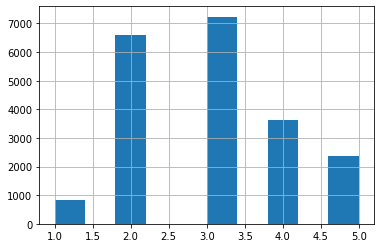

In [11]:
housing['income_cat'] = pd.cut(housing['median_income'], # Chopping up median income because it's important
                              bins=[0., 1.5, 3.0, 4.5, 6., np.inf], # Chop into categories of 0 to 1.5, 1.5 to 3, etc
                              labels=[1,2,3,4,5]) # Generic labels
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42) # Generic train/test split
housing['income_cat'].hist()
plt.show()


In [12]:
# Now we want to do some stratified sampling based on median_income which seems to be fairly important

split = SSS(n_splits=1, test_size=0.2, random_state=42) # Initialize our split with proper test size/random state to match book
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [13]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

In [14]:
# Make a table showing the how a stratified sampling ensures our test set matches our original distribution for median_income

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()

In [15]:
compare_props.head()

Overall  Stratified    Random
1  0.039826    0.039729  0.040213
2  0.318847    0.318798  0.324370
3  0.350581    0.350533  0.358527
4  0.176308    0.176357  0.167393
5  0.114438    0.114583  0.109496

In [16]:
# Now that we finished with our income_cat feature we can drop it

for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

In [17]:
# With our test set put aside we can explore the data

housing = strat_train_set.copy()

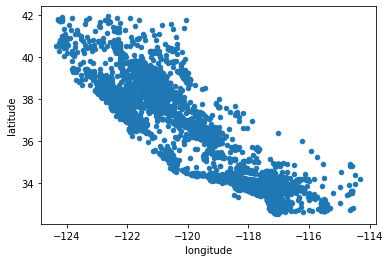

In [18]:
# Simple scatter plot

housing.plot(kind='scatter', x='longitude', y='latitude')
plt.show()

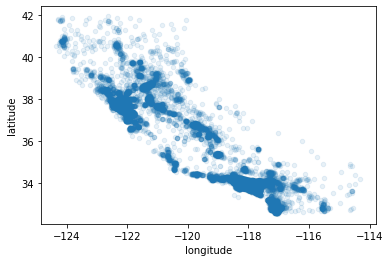

In [19]:
# Scatter plot emphasizing denser areas

housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)
plt.show()

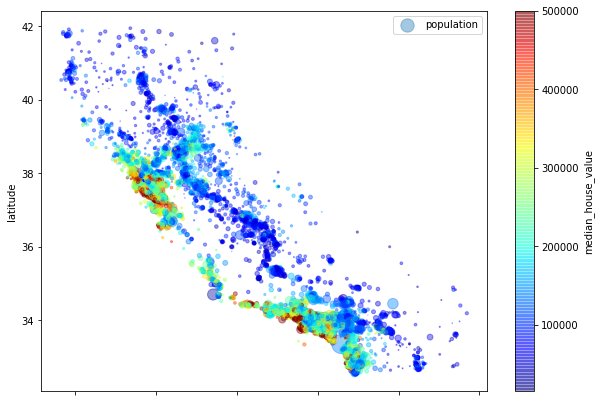

In [20]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, 
            s = housing['population'] / 100,  # Adjusit size of points to size of population
            label='population', 
            figsize=(10,7), 
            c = 'median_house_value', # Base color map on median house value
            cmap=plt.get_cmap('jet'), 
            colorbar=True)
plt.legend()
plt.xlabel=('longitude')

In [21]:
# Check out correlations

corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

We can see a strong correlation between house value and median income which is to be expected. However, we see almost no correlation geographically even though our heat map earlier suggests a strong corrolation between location and price. This just means the features have a non linear relation.

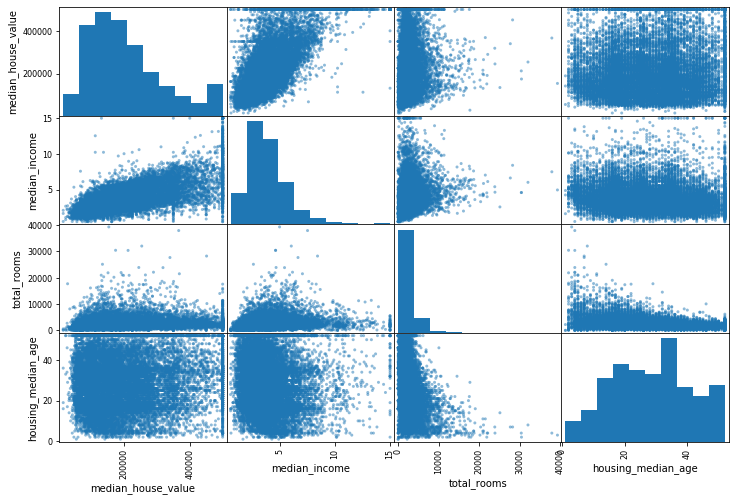

In [22]:
# Grab scatter plots between most promising features to inspect

attributes= ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()

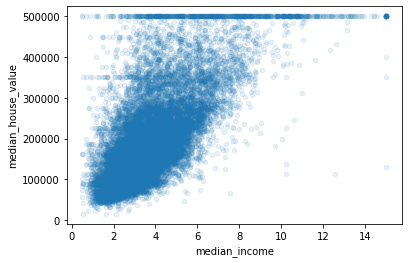

In [23]:
# Strongest looking correlation is between median income and median house value so we look more closely at that

housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)
plt.show()

We can see a strong correlation as well as a few oddities. There are some abnormal horizontal lines at 500k, 350k and possible 250k that may have to be dealt with later. Now we can move on to feature creation! Some useful features could be rooms per household (more useful than just the number of rooms), bedrooms per room (proportion of rooms which are actually bedrooms), and people per household.

In [24]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [25]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

We now see our artificial features and how correlated they are to the target feature with the most promising being rooms_per_household and bedrooms_per_room with a strong negative correlation. This makes intuitive sense when you consider a 4 bedroom 2.5 bath compared to a 3 bedroom 1 bath. Anothing factor could be extra non bedrooms such as extra living rooms and kitchens driving the price up considerably. With some decent correlations on our features we can move on to preping our data for ML algorithms.

In [26]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [27]:
housing.info() # Bring back up to see where we have null values (in total_bedrooms)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [28]:
# Median imputation using SkLearn

imputer = SimpleImputer(strategy='median')
housing_num = housing.drop('ocean_proximity', axis=1) # Drop non numerical feature for imputation
imputer.fit(housing_num) # Computes and stores median values for all features in housing_num which we may need later
X = imputer.transform(housing_num) # Apply median imputation
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index) # Remake our df from our numpy array X


In [29]:
# Check out our categorical feature
housing_cat = housing[['ocean_proximity']] # doubles brackets to get a dataframe instead of a series
housing_cat.head(10)

ocean_proximity
17606       <1H OCEAN
18632       <1H OCEAN
14650      NEAR OCEAN
3230           INLAND
3555        <1H OCEAN
19480          INLAND
8879        <1H OCEAN
13685          INLAND
4937        <1H OCEAN
4861        <1H OCEAN

In [30]:
housing['ocean_proximity']

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
            ...    
6563         INLAND
12053        INLAND
13908        INLAND
11159     <1H OCEAN
15775      NEAR BAY
Name: ocean_proximity, Length: 16512, dtype: object

In [31]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot # Note this is stored as a sparse matrix since most of the matrix would be empy anyways

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [32]:
housing_cat_1hot.toarray() # What our matrix looks like

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [33]:
cat_encoder.categories_ # List all our categories

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

SkLearn is very useful, but sometimes we need to create our own functions to modify the data. In doing so it is important to stay compatible with SkLearn by creating our own classes with the methods of fit(), transform(), and fit_transform(). Given example:

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [35]:
# Setup a pipeline to do all we've done already for numerical features
# Note that all estimators but the last must be transformers(specifically they must have a
# fit_transform() method)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()), 
    ('std_scaler', StandardScaler())
]) 

In [36]:
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [37]:
# Our previous pipeline applies to all columns in a dataframe. To deal with both our categorical and
# numerical features at once we use ColumnTransformer to perform our pipeline only on numerical features
# and OneHotEncoder only on categorical features

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs), 
    ('cat', OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

In [40]:
# Try out simple model

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [42]:
# Check out our error on training set

lin_reg_pred = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, lin_reg_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [44]:
# Better evaluation with Cross Validation (k-fold)

scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                        scoring='neg_mean_squared_error', cv=10)
lin_reg_rmse_scores = np.sqrt(-scores)

In [46]:
def display_scores(scores):
    print('Scores: ', scores)
    print('Mean: ', scores.mean())
    print('Standard Deviation: ', scores.std())

In [48]:
display_scores(lin_reg_rmse_scores)

Scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean:  69052.46136345083
Standard Deviation:  2731.6740017983425


In [51]:
# Random Forest

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
forest_reg_pred = forest_reg.predict(housing_prepared)
forest_reg_mse = mean_squared_error(housing_labels, forest_reg_pred)
forest_reg_rmse = np.sqrt(forest_reg_mse)
forest_reg_rmse

c:\users\tsb\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


22020.531016739864

In [53]:
# Get k-fold scores

forest_reg_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                        scoring='neg_mean_squared_error', cv=10)
forest_reg_rmse_scores = np.sqrt(-forest_reg_scores)

In [54]:
# Display

display_scores(forest_reg_rmse_scores)

Scores:  [51471.26384635 50121.66522618 53509.84575046 54704.7006039
 52832.4840061  57155.84968564 52357.59400134 51823.56197907
 56258.53544821 52717.53079744]
Mean:  53295.303134468486
Standard Deviation:  2066.62611382041


In [60]:
# Save our models

joblib.dump(lin_reg, "models/lin_reg.pkl")
joblib.dump(forest_reg, "models/forest_reg.pkl")

# Note: can load back in with joblib.load('path/model.pkl')

['models/forest_reg.pkl']

In [63]:
# Fine tuning our models (Grid Search)

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],


In [64]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [65]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [66]:
# Display rmse for each of the models tested in our Grid Search

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

63766.249031932166 {'max_features': 2, 'n_estimators': 3}
55241.42801213305 {'max_features': 2, 'n_estimators': 10}
52535.380892189394 {'max_features': 2, 'n_estimators': 30}
59700.32170336908 {'max_features': 4, 'n_estimators': 3}
52924.53101060204 {'max_features': 4, 'n_estimators': 10}
50393.77338577394 {'max_features': 4, 'n_estimators': 30}
59301.43966695725 {'max_features': 6, 'n_estimators': 3}
52035.17103216119 {'max_features': 6, 'n_estimators': 10}
49813.18816875522 {'max_features': 6, 'n_estimators': 30}
58081.320376052456 {'max_features': 8, 'n_estimators': 3}
51737.611817250836 {'max_features': 8, 'n_estimators': 10}
50338.53670533141 {'max_features': 8, 'n_estimators': 30}
62649.34948878523 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54152.03055272061 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59796.1703788161 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52826.151917810435 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [69]:
# Look into how important each feature is in deciding our output and consider dropping less important

feature_importances = grid_search.best_estimator_.feature_importances_

extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.29557797449661544, 'median_income'),
 (0.15501755658961477, 'INLAND'),
 (0.10808150971584977, 'pop_per_hhold'),
 (0.09567946033989604, 'bedrooms_per_room'),
 (0.08025900590023524, 'longitude'),
 (0.07448394445267537, 'latitude'),
 (0.06378150432622012, 'rooms_per_hhold'),
 (0.04012776886007714, 'housing_median_age'),
 (0.017890873234094058, 'total_rooms'),
 (0.016940497934044608, 'population'),
 (0.01665603928514349, 'households'),
 (0.01572966535262306, 'total_bedrooms'),
 (0.010971161123643354, '<1H OCEAN'),
 (0.004910668398105027, 'NEAR OCEAN'),
 (0.003847444862073042, 'NEAR BAY'),
 (4.4925129089441225e-05, 'ISLAND')]

In [71]:
# Final post tuning evaluation on our test set

final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value']

X_test_prepared = full_pipeline.transform(X_test)

final_pred = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_pred)
final_rmse = np.sqrt(final_mse)

In [72]:
# Definitive RMSE score for our tuned model

print(final_rmse)

47702.116203907615


In [74]:
# 95% confidence interval for our RMSE

confidence = 0.95
squared_errors = (final_pred - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                        loc=squared_errors.mean(),
                        scale=stats.sem(squared_errors)))

array([45750.65472887, 49576.82293716])

In [75]:
# 95% sure our RMSE on actual data would be between 45750 and 49576

In [76]:
# Save our model

joblib.dump(final_model, 'models/final_model.pkl')

['models/final_model.pkl']